# Post-Processing

#### Updated: Aug 17, 2023

#  

Post-processing pipeline after Stage 2 of Alouette processing (OCR processing stage):

In [304]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [305]:
rootDir = '' #The file path to the root directory for your project
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [306]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate Stage 1 results - RUN BEFORE starting Stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [4]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

R014207815
R014207816
R014207821
R014207823
R014207824
R014207832
R014207840
R014207841
R014207842
R014207844
R014207907F
R014207908F
R014207909F
R014207929F
R014207930F
R014207938
R014207939
R014207940F
R014207942
R014207943
R014207946
R014207947
R014207948
R014207949
R014207951
R014207953
R014207954
R014207955
R014207956
R014207957
R014207958
R014207959
R014207960
R014207962
R014207964
R014207965
R014207966
R014207967
R014207968
R014207970
R014207974
R014207975
R014207978F
R014207979F
R014207980


In [5]:
print(len(df_inventory))
df_inventory.head()

2534


,Directory,Subdirectory,images,subdir_id
0,R014207815,3488-15A,273,R014207815_3488-15A
1,R014207815,3489-15A,281,R014207815_3489-15A
2,R014207815,3490-15A,198,R014207815_3490-15A
3,R014207815,3491-8A,289,R014207815_3491-8A
4,R014207815,3492-8A,334,R014207815_3492-8A


In [6]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [7]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

Now saving the 100th result...
28997
Now saving the 200th result...
57948
Now saving the 300th result...
87219
Now saving the 400th result...
116911
Now saving the 500th result...
144360
Now saving the 600th result...
173007
Now saving the 700th result...
209897
Now saving the 800th result...
244500
Now saving the 900th result...
280535
Now saving the 1000th result...
315153
Now saving the 1100th result...
350668
Now saving the 1200th result...
380820
Now saving the 1300th result...
410134
Now saving the 1400th result...
440793
Now saving the 1500th result...
471356
Now saving the 1600th result...
502143
Now saving the 1700th result...
533390
Now saving the 1800th result...
563595
Now saving the 1900th result...
595100
Now saving the 2000th result...
626640
Now saving the 2100th result...
657501
Now saving the 2200th result...
691176
Now saving the 2300th result...
723750
Now saving the 2400th result...
755452
Now saving the 2500th result...
790760
Now saving the 2600th result...
82798

In [8]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

c:\DevSoftware\Anaconda38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17,20,23,24,25,26,27,28,29,30,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


841115


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,window_coord,mapping_Hz,mapping_km,details,Directory,Subdirectory,filename,station_code,station_number,rotated_metadata
679927,1.532258,1320.408163,1.0,3.0,2.0,0.0,3.0,0.0,8.0,5.0,...,NaN,NaN,NaN,NaN,R014207966,1163-5A,125.png,NaN,NaN,NaN
560051,1.625000,1105.555556,1.0,5.0,1.0,6.0,0.0,1.0,3.0,2.0,...,NaN,NaN,NaN,NaN,R014207957,2640-18B,209.png,NaN,NaN,NaN
785504,1.701613,242.307692,1.0,3.0,0.0,2.0,2.0,1.0,4.0,1.0,...,NaN,NaN,NaN,NaN,R014207975,1135-B,83.png,NaN,NaN,NaN
513414,1.524194,872.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[[1229. 4.]\n [1230. 4.]\n [1231. 4.]...,"{1.5: 149, 2.0: 273, 2.5: 335, 3.5: 390, 4.5: ...","{100: 49, 200: 99}",NaN,R014207955,2842-50B,197.png,NaN,NaN,NaN
252959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,R014207929F,477,Image0287.png,NaN,NaN,NaN
750248,1.500000,1416.666667,1.0,3.0,3.0,2.0,6.0,2.0,0.0,3.0,...,NaN,NaN,NaN,NaN,R014207970,1381-1B,154.png,NaN,NaN,NaN
673575,4.169811,2038.235294,1.0,4.0,1.0,1.0,4.0,1.0,7.0,0.0,...,NaN,NaN,NaN,NaN,R014207965,1685-5A,300.png,NaN,NaN,NaN
332170,1.564516,1274.418605,NaN,NaN,0.0,6.0,2.0,3.0,4.0,0.0,...,NaN,NaN,NaN,NaN,R014207940F,390,Image0207.png,4.0,4.0,NaN
366254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,R014207943,2062-1A,121.png,NaN,NaN,NaN
496760,1.500000,1155.357143,1.0,4.0,3.0,3.0,7.0,1.0,0.0,5.0,...,NaN,NaN,NaN,NaN,R014207954,2189-4B,309.png,NaN,NaN,NaN


#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [108]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
28588
Now saving the 200th result...
67746
Now saving the 300th result...
100086
Now saving the 400th result...
130480
Now saving the 500th result...
159178
Now saving the 600th result...
188434
Now saving the 700th result...
218031
Now saving the 800th result...
244454
Now saving the 900th result...
273755
Now saving the 1000th result...
302594
Now saving the 1100th result...
330088
Now saving the 1200th result...
358780
Now saving the 1300th result...
387101
Now saving the 1400th result...
417885
Now saving the 1500th result...
442633
Now saving the 1600th result...
473125
Now saving the 1700th result...
505976
Now saving the 1800th result...
540364
Now saving the 1900th result...
574151


#  

#### Reduce columns:

In [307]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

600621


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,Subdirectory,filename,station_code,station_number,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,1.500000,1443.396226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,191.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.504032,405.660377,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,...,24,218.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.500000,1537.735849,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,24,33.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.650538,1490.566038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,83.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [308]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
524329,R014207961,1040,92.png,num,1.524194,872.549020,NaN,0.0,9.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175296,R014207825,3752-19A,229.png,loss,6.753968,631.914894,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
435585,R014207941,1773-1,199.png,num,1.737903,1354.901961,NaN,0.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2507,R014207807,4941,192.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata_translation.determine_leftside_metada...,NaN
257451,R014207830,3688-50A,187.png,loss,1.504032,685.106383,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
174485,R014207825,3748-8A,195.png,loss,1.500000,1089.583333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
571610,R014207969,1302-18B,206.png,num,1.500000,978.000000,NaN,1.0,8.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492785,R014207950,2504-5-B,192.png,num,1.520161,1316.981132,NaN,0.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438070,R014207941,1783-3A,4.png,num,1.524194,1390.384615,NaN,1.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467928,R014207945,2246-9A,215.png,num,1.552419,1422.448980,NaN,0.0,9.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  

#### Split results into different metadata types (dot, num, num2):

In [309]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'dot', 'num2'], dtype=object)

In [310]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

105414


In [311]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

161109


In [312]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

7337


In [313]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

54861


In [314]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

271900


In [315]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

600621

#### num2 - check timestamp components, construct timestamp:

In [316]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
383931,65.0,221,22,24,17
221139,68.0,079,04,30,28
276998,67,84.0,20,09,12
202378,66.0,364.0,11.0,38,59
307429,67.0,361,16.0,32.0,36
92503,67.0,157.0,18.0,27,29
403756,67.0,289,15,19,25
315284,66.0,91.0,1.0,06,39
304212,68.0,94.0,14.0,40,30
105796,67.0,289.0,08,25,15


year:

<AxesSubplot:xlabel='year_OCR', ylabel='Count'>

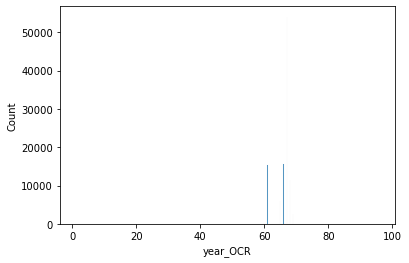

In [317]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [318]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [319]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
236452,1967.0,67.0
102451,1967.0,67.0
156137,1966.0,66.0
383243,1968.0,68.0
210042,1966.0,66.0
116296,1967.0,67.0
275627,NaN,NaN
200057,1967.0,67.0
278718,1967.0,67.0
277166,1967.0,67.0


day:

<AxesSubplot:xlabel='day_of_year_OCR', ylabel='Count'>

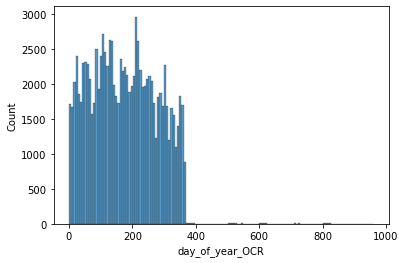

In [320]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [321]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
114670,NaN,NaN
131257,143.0,143.0
298428,27.0,27.0
399257,234.0,234.0
301972,34.0,34.0
381863,190.0,190.0
297026,357.0,357.0
332504,326.0,326.0
333346,54.0,54.0
296226,346.0,346.0


hour:

<AxesSubplot:xlabel='hour_OCR', ylabel='Count'>

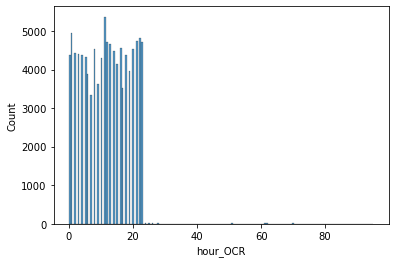

In [322]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [323]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
286240,18.0,18.0
279555,21.0,21.0
321276,5.0,5.0
402116,3.0,3.0
293630,8.0,8.0
320033,2.0,2.0
300426,12.0,12.0
326255,12.0,12.0
85391,22.0,22.0
189742,3.0,3.0


minute:

<AxesSubplot:xlabel='minute_OCR', ylabel='Count'>

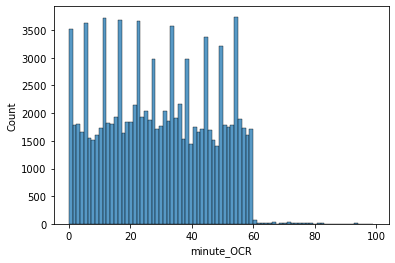

In [324]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [325]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
92597,48.0,48.0
90553,53.0,53.0
303137,53.0,53.0
357399,22.0,22.0
406619,28.0,28.0
391717,4.0,4.0
190075,20.0,20.0
90012,40.0,40.0
275100,55.0,55.0
331081,30.0,30.0


second:

<AxesSubplot:xlabel='second_OCR', ylabel='Count'>

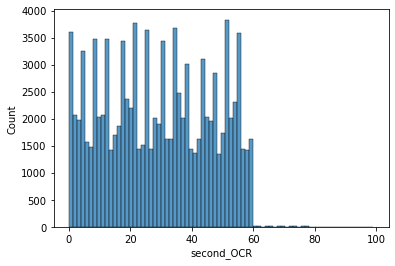

In [326]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [327]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
280831,50.0,50.0
304650,57.0,57.0
327188,5.0,5.0
360750,47.0,47.0
349073,29.0,29.0
390360,18.0,18.0
239346,9.0,9.0
152379,17.0,17.0
116492,21.0,21.0
129412,17.0,17.0


construct timestamp:

In [328]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

105414


In [329]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality', 'satellite_number']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality,satellite_number
312889,1968.0,05,25,15.0,30.0,48.0,1968-05-25 15:30:48,1,NaN
275724,1967.0,03,15,1.0,48.0,5.0,1967-03-15 01:48:05,1,NaN
151011,1965.0,11,03,11.0,16.0,22.0,1965-11-03 11:16:22,1,NaN
403427,1967.0,10,12,14.0,39.0,25.0,1967-10-12 14:39:25,1,NaN
363160,NaN,06,11,17.0,55.0,46.0,NaT,0,NaN
365913,NaN,07,07,3.0,40.0,17.0,NaT,0,NaN
278410,1967.0,04,07,15.0,56.0,48.0,1967-04-07 15:56:48,1,NaN
324905,1966.0,08,13,4.0,44.0,27.0,1966-08-13 04:44:27,1,NaN
397685,NaN,09,06,3.0,3.0,16.0,NaT,0,NaN
367707,1967.0,01,06,2.0,50.0,50.0,1967-01-06 02:50:50,1,NaN


#  

#### num - check satellite number, check timestamp components, construct timestamp:

Filter for satellite_number == 1:

In [330]:
print(len(df_num))
df_num = df_num.loc[df_num['satellite_number'] == 1]
print(len(df_num))
df_num.head()

161109
119520


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
0,R014207711,24,191.png,num,1.500000,1443.396226,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R014207711,24,33.png,num,1.500000,1537.735849,NaN,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,R014207711,25,4.png,num,1.500000,1434.883721,NaN,1.0,1.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576,R014207711,29,24.png,num,4.198113,1165.573770,NaN,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577,R014207711,29,262.png,num,5.995327,1329.508197,NaN,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check timestamp components, construct timestamp:

In [331]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
436066,4.0,1.0,7.0,0.0,1.0,3.0,2.0,8.0,4.0,3.0
455927,4.0,2.0,3.0,2.0,0.0,0.0,5.0,3.0,2.0,8.0
439751,4.0,1.0,4.0,2.0,1.0,3.0,3.0,3.0,0.0,0.0
567373,3.0,2.0,6.0,0.0,0.0,5.0,5.0,8.0,4.0,4.0
482021,5.0,1.0,9.0,8.0,1.0,4.0,3.0,6.0,5.0,4.0
467643,4.0,2.0,7.0,7.0,0.0,3.0,1.0,3.0,0.0,7.0
554442,4.0,0.0,8.0,7.0,0.0,0.0,2.0,2.0,3.0,7.0
565126,3.0,2.0,9.0,5.0,0.0,4.0,5.0,4.0,3.0,0.0
464704,4.0,3.0,1.0,1.0,2.0,3.0,5.0,9.0,5.0,8.0
452742,4.0,2.0,8.0,1.0,2.0,2.0,3.0,7.0,1.0,6.0


year - adjust to baseline 1962:

<AxesSubplot:xlabel='year', ylabel='Count'>

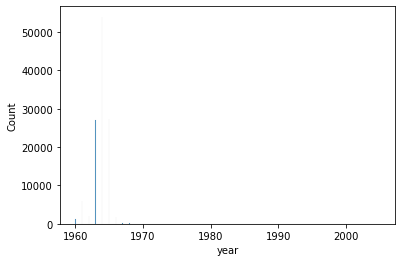

In [332]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1960 #1962 
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [333]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
473455,1964.0,4.0
522395,1963.0,3.0
427511,1964.0,4.0
532654,1963.0,3.0
537237,1963.0,3.0
448998,1964.0,4.0
577814,1963.0,3.0
483059,1965.0,5.0
551209,1964.0,4.0
427892,1964.0,4.0


day:

<AxesSubplot:xlabel='day_1', ylabel='Count'>

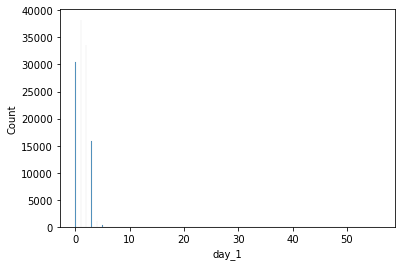

In [334]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [335]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_2', ylabel='Count'>

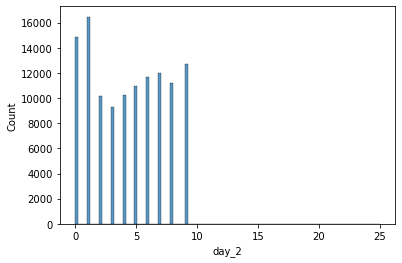

In [336]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [337]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_3', ylabel='Count'>

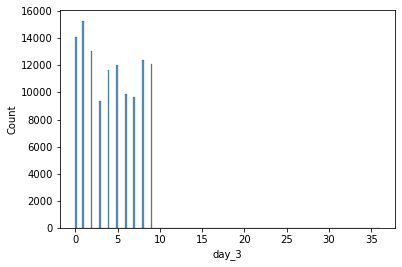

In [338]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [339]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [340]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

119520


,day_of_year,day_1,day_2,day_3
437894,183.0,1.0,8.0,3.0
15005,211.0,2.0,1.0,1.0
553734,54.0,0.0,5.0,4.0
182039,301.0,3.0,0.0,1.0
434776,155.0,1.0,5.0,5.0
443696,177.0,1.0,7.0,7.0
459350,280.0,2.0,8.0,0.0
461253,327.0,3.0,2.0,7.0
512997,55.0,0.0,5.0,5.0
572469,124.0,1.0,2.0,4.0


hour:

<AxesSubplot:xlabel='hour_1', ylabel='Count'>

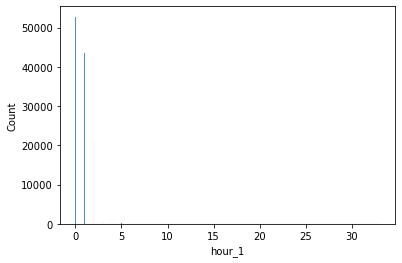

In [341]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [342]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='hour_2', ylabel='Count'>

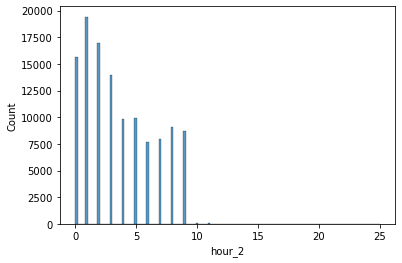

In [343]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [344]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [345]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

119520


,hour,hour_1,hour_2
466010,7.0,0.0,7.0
453377,19.0,1.0,9.0
566474,7.0,0.0,7.0
539100,12.0,1.0,2.0
496935,18.0,1.0,8.0
567031,3.0,0.0,3.0
534252,21.0,2.0,1.0
499064,19.0,1.0,9.0
495553,4.0,0.0,4.0
519447,8.0,0.0,8.0


minute:

<AxesSubplot:xlabel='minute_1', ylabel='Count'>

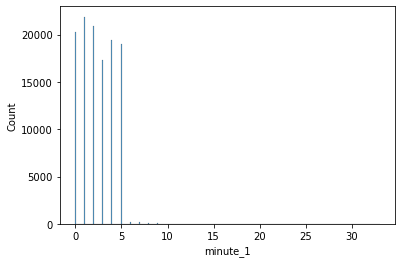

In [346]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [347]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='minute_2', ylabel='Count'>

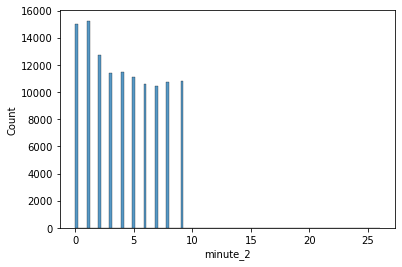

In [348]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [349]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [350]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

119520


,minute,minute_1,minute_2
462434,47.0,4.0,7.0
539052,8.0,0.0,8.0
431233,36.0,3.0,6.0
442807,19.0,1.0,9.0
440266,39.0,3.0,9.0
461559,15.0,1.0,5.0
502240,22.0,2.0,2.0
570895,26.0,2.0,6.0
493317,42.0,4.0,2.0
451506,31.0,3.0,1.0


second:

<AxesSubplot:xlabel='second_1', ylabel='Count'>

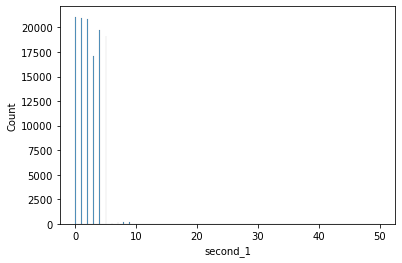

In [351]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [352]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='second_2', ylabel='Count'>

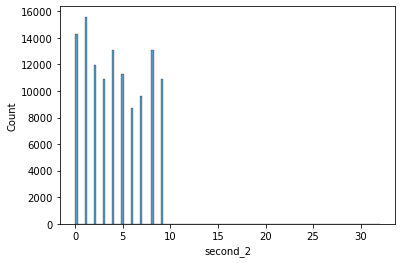

In [353]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [354]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [355]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

119520


,second,second_1,second_2
376899,2.0,0.0,2.0
579502,49.0,4.0,9.0
471171,15.0,1.0,5.0
466014,6.0,0.0,6.0
541896,50.0,5.0,0.0
551525,49.0,4.0,9.0
458311,25.0,2.0,5.0
432745,41.0,4.0,1.0
566148,30.0,3.0,0.0
516841,54.0,5.0,4.0


construct timestamp:

In [356]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

119520


In [357]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality', 'satellite_number']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality,satellite_number
583628,NaN,04,21,2.0,11.0,12.0,NaT,0,1.0
479613,1965.0,03,29,17.0,20.0,9.0,1965-03-29 17:20:09,1,1.0
432224,1964.0,05,20,NaN,NaN,0.0,1964-05-20 00:00:00,4,1.0
490159,1965.0,03,18,1.0,57.0,1.0,1965-03-18 01:57:01,1,1.0
484729,1965.0,02,22,1.0,4.0,57.0,1965-02-22 01:04:57,1,1.0
574091,1963.0,05,15,5.0,10.0,36.0,1963-05-15 05:10:36,1,1.0
170269,NaN,04,21,11.0,20.0,21.0,NaT,0,1.0
460255,1966.0,10,15,16.0,16.0,11.0,1966-10-15 16:16:11,1,1.0
447389,1964.0,09,08,9.0,18.0,41.0,1964-09-08 09:18:41,1,1.0
487548,1964.0,10,04,3.0,9.0,3.0,1964-10-04 03:09:03,1,1.0


#  

#### dot - check satellite number, check timestamp components, construct timestamp:

Check satellite number:

In [358]:
df_dot['satellite_number'].unique()

array([nan])

- it appears that satellite_number does not get read in Stage 1 processing.

Check timestamp components, construct timestamp:

In [359]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot', 'satellite_number']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot,satellite_number
533145,NaN,1.0,8.0,0.0,9.0,8.0,8.0,0.0,24.0,1.0,NaN,NaN
446765,NaN,1.0,0.0,8.0,10.0,1.0,0.0,2.0,8.0,0.0,NaN,NaN
459642,NaN,1.0,8.0,0.0,10.0,0.0,8.0,0.0,8.0,0.0,NaN,NaN
530582,NaN,1.0,16.0,8.0,9.0,8.0,1.0,1.0,9.0,0.0,NaN,NaN
539466,NaN,1.0,8.0,0.0,18.0,0.0,8.0,0.0,0.0,1.0,NaN,NaN
523795,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
531257,NaN,1.0,8.0,8.0,9.0,16.0,1.0,0.0,1.0,0.0,NaN,NaN
532979,NaN,1.0,8.0,8.0,18.0,0.0,0.0,0.0,9.0,0.0,NaN,NaN
531265,NaN,1.0,8.0,0.0,8.0,9.0,8.0,0.0,17.0,0.0,NaN,NaN
519860,NaN,8.0,0.0,16.0,0.0,8.0,0.0,8.0,8.0,0.0,NaN,NaN


day:

<AxesSubplot:xlabel='day_1', ylabel='Count'>

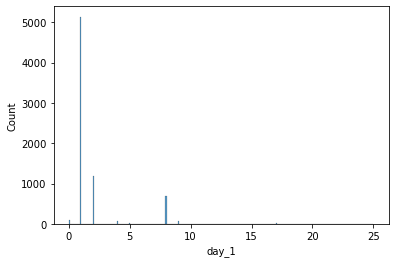

In [360]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [361]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_2', ylabel='Count'>

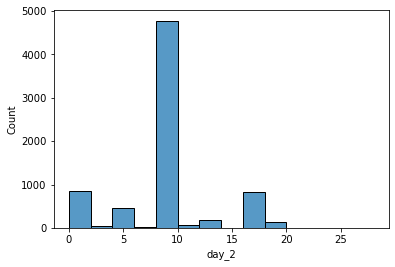

In [362]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [363]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_3', ylabel='Count'>

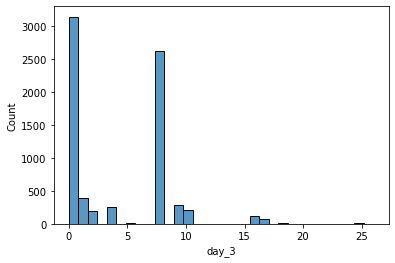

In [364]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [365]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [366]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

7337


,day_of_year,day_1,day_2,day_3
538733,181.0,1.0,8.0,1.0
446800,288.0,2.0,8.0,8.0
449573,NaN,8.0,8.0,0.0
448560,188.0,1.0,8.0,8.0
530417,NaN,1.0,NaN,8.0
519908,NaN,8.0,0.0,NaN
519650,NaN,8.0,8.0,8.0
534451,NaN,8.0,0.0,0.0
530612,NaN,1.0,NaN,8.0
446738,180.0,1.0,8.0,0.0


year - infer from day:

In [367]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

c:\DevSoftware\Anaconda38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,year,day_of_year,day_1,day_2,day_3
536779,1962.0,288.0,2.0,8.0,8.0
521625,NaN,NaN,4.0,0.0,0.0
537018,1962.0,288.0,2.0,8.0,8.0
539732,NaN,NaN,2.0,NaN,8.0
527869,1963.0,188.0,1.0,8.0,8.0
520734,NaN,NaN,1.0,NaN,8.0
519724,NaN,NaN,8.0,0.0,8.0
446817,1963.0,180.0,1.0,8.0,0.0
519908,NaN,NaN,8.0,0.0,NaN
535930,1963.0,180.0,1.0,8.0,0.0


hour:

<AxesSubplot:xlabel='hour_1', ylabel='Count'>

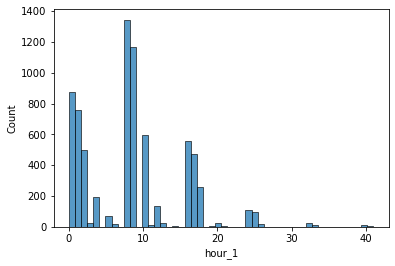

In [368]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [369]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='hour_2', ylabel='Count'>

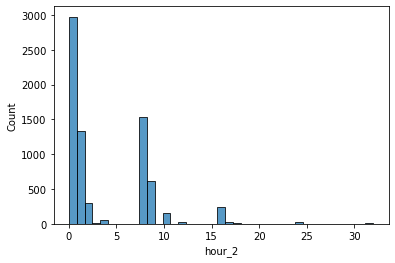

In [370]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [371]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [372]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

7337


,hour,hour_1,hour_2
449386,1.0,0.0,1.0
521552,NaN,8.0,0.0
539344,NaN,8.0,8.0
450384,NaN,0.0,NaN
449480,0.0,0.0,0.0
536064,NaN,9.0,8.0
535302,NaN,NaN,0.0
519773,0.0,0.0,0.0
519730,NaN,8.0,0.0
536929,21.0,2.0,1.0


minute:

<AxesSubplot:xlabel='minute_1', ylabel='Count'>

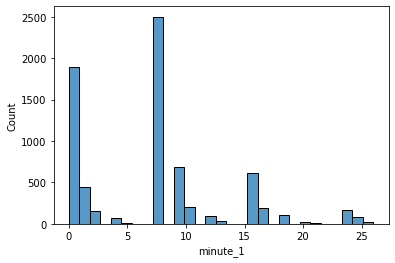

In [373]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [374]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='minute_2', ylabel='Count'>

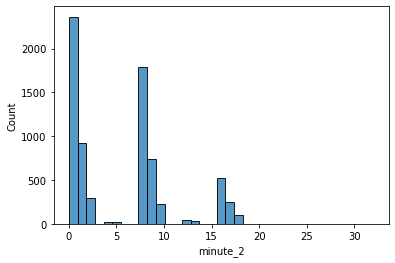

In [375]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [376]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [377]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

7337


,minute,minute_1,minute_2
460810,NaN,0.0,NaN
460751,NaN,0.0,NaN
533830,NaN,8.0,1.0
455280,9.0,0.0,9.0
445340,NaN,8.0,0.0
536819,19.0,1.0,9.0
537008,NaN,NaN,8.0
459557,NaN,8.0,8.0
531101,NaN,0.0,NaN
533654,NaN,9.0,0.0


second:

<AxesSubplot:xlabel='second_1', ylabel='Count'>

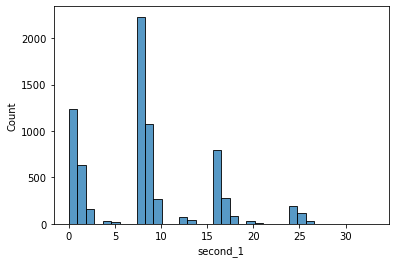

In [378]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [379]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='second_2', ylabel='Count'>

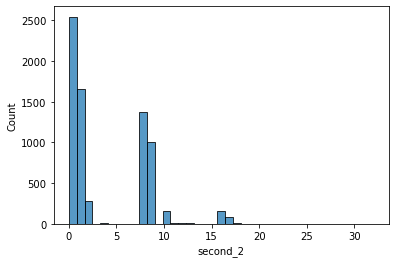

In [380]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [381]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [382]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

7337


,second,second_1,second_2
535223,NaN,NaN,9.0
533710,10.0,1.0,0.0
534611,NaN,8.0,0.0
520054,NaN,NaN,1.0
523686,NaN,NaN,2.0
450568,NaN,NaN,0.0
536021,10.0,1.0,0.0
538710,19.0,1.0,9.0
523682,NaN,9.0,0.0
536329,NaN,8.0,0.0


construct timestamp:

In [383]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

7337


In [384]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality', 'satellite_number']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality,satellite_number
535169,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4,NaN
519711,NaN,NaN,NaN,0.0,NaN,NaN,NaT,0,NaN
536939,1962.0,10,15,NaN,NaN,NaN,1962-10-15 00:00:00,4,NaN
531107,1963.0,07,07,NaN,1.0,NaN,1963-07-07 00:00:00,4,NaN
530487,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4,NaN
449397,1963.0,06,29,11.0,11.0,NaN,1963-06-29 11:11:00,2,NaN
539800,1963.0,07,08,NaN,NaN,NaN,1963-07-08 00:00:00,4,NaN
520063,1963.0,06,11,20.0,NaN,10.0,1963-06-11 20:00:00,3,NaN
530438,1963.0,07,07,NaN,8.0,NaN,1963-07-07 00:00:00,4,NaN
531192,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0,NaN


#  

#### Check station number:

num2:

<AxesSubplot:xlabel='station_number_OCR', ylabel='Count'>

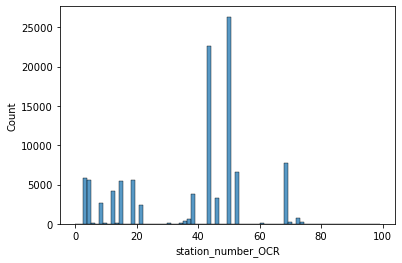

In [385]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [386]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
349392,50.0,50.0
116490,15.0,15.0
394743,43.0,43.0
291377,3.0,3.0
323617,53.0,53.0
390426,43.0,43.0
288972,12.0,12.0
388251,43.0,43.0
391820,43.0,43.0
394843,43.0,43.0


num:

<AxesSubplot:xlabel='station_number_1', ylabel='Count'>

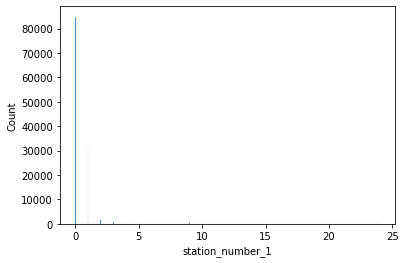

In [387]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [388]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='station_number_2', ylabel='Count'>

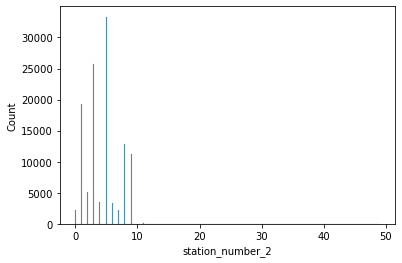

In [389]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [390]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [391]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

119520


,station_number,station_number_1,station_number_2
484105,8.0,0.0,8.0
505761,13.0,1.0,3.0
508671,13.0,1.0,3.0
572719,3.0,0.0,3.0
561287,13.0,1.0,3.0
490730,5.0,0.0,5.0
482536,1.0,0.0,1.0
562101,13.0,1.0,3.0
434488,3.0,0.0,3.0
171177,12.0,1.0,2.0


dot:

In [392]:
df_dot[['station_number']].sample(10)

,station_number
460737,17.0
521465,25.0
535939,8.0
450385,9.0
536059,16.0
531146,16.0
523310,41.0
531203,20.0
539458,10.0
533881,24.0


#  

#### Recombine results, save:

In [393]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

559032


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
127350,R014207819,4771-46-2,46.png,loss,1.508065,1508.888889,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
295332,R014207833,4354-50A,229.png,num2,1.721774,1406.000000,50.0,NaN,NaN,NaN,...,NaN,330.0,20.0,4.0,8.0,0.0,11-26,11,26,NaT
96269,R014207817,4187-5,204.png,loss,1.705645,1352.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
170365,R014207825,3734-15A,238.png,num,1.524096,1452.083333,12.0,1.0,2.0,1.0,...,NaN,111.0,11.0,20.0,21.0,0.0,04-21,04,21,NaT
241877,R014207829,4289-37,206.png,loss,1.500000,1441.176471,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
172794,R014207825,3742-43A,260.png,loss,1.576613,1270.212766,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
213942,R014207827,3825-43A,160.png,loss,1.500000,1350.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
151253,R014207820,2998-43A,290.png,loss,1.500000,1206.122449,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
570080,R014207969,1297-5A,30.png,num,1.705645,1350.000000,5.0,0.0,5.0,3.0,...,1963.0,304.0,19.0,5.0,30.0,1.0,10-31,10,31,1963-10-31 19:05:30
444767,R014207941,1806-5B,41.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Save:

In [394]:
df_result2.to_csv(resultDir + 'result_postprocess_raw[1960_baseline].csv', index=False)
#df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [395]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [396]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [397]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [398]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
1801
1963-04-25 00:00:00
3306
1963-08-06 00:00:00
14092
1965-07-01 00:00:00
114145
After 1965-07-01 00:00:00
205014


In [399]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [400]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

205014


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
114604,19.0,1966-05-30 23:36:45,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W
148186,43.0,1967-01-30 07:56:09,RES,"Resolute Bay, NT, Canada",74.7N,95W
85098,7.0,1963-10-11 01:52:50,QUI,"Quito, Ecuador",0.6S,78.6W
80001,9.0,1963-09-24 03:42:38,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
117773,8.0,1967-02-27 08:21:38,SNT,"Santiago, Chile",33.2S,70.1W
119275,3.0,1967-04-25 23:56:29,FTM,"Fort Myers, FL, USA",26.6N,81.9W
111092,5.0,1963-11-17 01:45:39,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
29378,5.0,1964-06-28 11:52:36,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
137924,50.0,1967-01-22 00:55:37,OTT,"Ottawa, Canada",45.4N,75.7W
176502,19.0,1967-05-24 16:58:52,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W


#  

#### Save Master:

In [401]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

199051


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
185841,R014207837,3991-50,160.png,num2,2.217742,2495.833333,1967-05-19 21:09:55,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
41803,R014207945,2239-3A,285.png,num,1.697581,1196.000000,1965-02-25 20:27:54,1.0,3.0,OTT,"Ottawa, Canada",45.4N,75.7W
88821,R014207963,1522-1B,275.png,num,1.532258,1438.000000,1964-02-01 08:29:00,1.0,1.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
142029,R014207827,3829-50A,247.png,num2,1.500000,1581.250000,1967-01-03 03:15:35,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
21739,R014207941,1770-13,82.png,num,1.661290,1471.428571,1964-06-02 09:37:27,1.0,13.0,GRK,"East Grant Forks, MN, USA",48N,97.1W
80305,R014207961,1042,308.png,num,1.500000,1462.745098,1963-09-30 04:08:25,1.0,9.0,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
106802,R014207969,1292-5A,326.png,num,1.729839,1447.916667,1963-10-30 01:02:18,1.0,5.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
52462,R014207950,2468-B-1,347.png,num,1.725806,1354.716981,1965-06-05 12:28:00,1.0,1.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
125143,R014207818,4213-69-2,236.png,num2,1.673387,1396.000000,1967-08-10 02:16:22,1.0,69.0,TRO,"Tromso, Norway",69.7N,18.9E
166436,R014207834,4475-12,144.png,num2,1.524194,1423.684211,1968-01-30 09:17:05,1.0,12.0,NEW,"St. John's, NL, Canada",47.6N,52.4W


In [402]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master[1960_baseline].csv', index=False)
#df_result5.to_csv(resultDir + 'result_master.csv', index=False)